In [3]:
#import thinkplot
#import thinkstats2
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import thinkplot
import thinkstats2
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)

# Assignment 3 - Basic Predictions and Regression

## Questions

### Part 1 - Election Prediction

Suppose you are looking at an election in a fictional province. There are 7 total elctoral districts, and the winner in each district is determined by a first-past-the-post system (what we have in Canada - the most votes wins, regardless of share). There are two parties - the Purples and the Yellows. Whoever controls the most seats will be the ruling party - so in our 2 party scenario, the party who wins 4 or more of the districts will govern. There is an election every year, they love voting. 

Recent polling indicating the expected vote share in each district is shown in the "dist_polls" table below. These values are a composite of several polls that the experts have combined and weighted. The "Purple" values show the expected vote share of the Purple party, along with the variance of that expectation and the number of polls that were combined to get that result.  

As well, research has shown that the vote distribution is impacted by voter turnout. In general, the more people vote, the more the vote split shifts towards the Yellow party. We have data on past elections and the results, we expect that the turnout will be in line with the past elections - or more specifically, we have no reason to expect it to differ. This impact is measured in the table in code below - that table shows the voter turnout, in a percentage, as well as the change in the Yellow party's vote share (also in percentage) as compared to the polling averages. For example, if one row showed "52" and ".8", that would mean that voter turnout was 52%, and the Yellow party got .8% higher of a vote share than the polling showed. 

<b>What is the probability that the Purple Party controls the government after the election?</b>

<b>Note:</b> the errors and confidence intervals are not totally trivial. As part of the written answer, offer an evaluation of your confidence in the prediction, and why you think that. This is not a question with one specific error, your estimation will have some expected errors, somewhere. You may not have the tools to calculate it all the way through, that's fine. 

### Question 1 - Your Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul>
<li>
<li>
<li>
<li> <b> What do you think about the error/accuracy:</b>
</ul>

##### Setup Poll Data

The dataframe "dist_polls" contains all of the polls for each seat. Each value is expressed as expected vote share (as a ratio) for the <b>Purple</b> party. The Yellow party can be safely assumed to get the rest of the votes. 

In [4]:
# Please don't edit this part. 
# Setup polling data. 
districts = [1,2,3,4,5,6,7]
dist_polls = pd.DataFrame(districts, columns=["district"])

dist_polls["Poll_1"] = [.55, .49, .51, .6, .41, .46, .54]
dist_polls["Poll_2"] = [.53, .51, .51, .62, .44, .48, .53]
dist_polls["Poll_3"] = [.51, .49, .53, .61, .42, .46, .52]
dist_polls["Poll_4"] = [.47, .48, .51, .54, .45, .45, .51]
dist_polls["Poll_5"] = [.61, .52, .49, .73, .44, .51, .53]
dist_polls["Poll_6"] = [.54, .45, .51, .61, .47, .52, .52]
dist_polls["Poll_7"] = [.55, .47, .5, .56, .47, .46, .56]
dist_polls["Poll_8"] = [.53, .49, .51, .55, .43, .49, .55]
dist_polls["Poll_9"] = [.57, .39, .52, .57, .53, .43, .53]


dist_polls.head(7)

,district,Poll_1,Poll_2,Poll_3,Poll_4,Poll_5,Poll_6,Poll_7,Poll_8,Poll_9
0,1,0.55,0.53,0.51,0.47,0.61,0.54,0.55,0.53,0.57
1,2,0.49,0.51,0.49,0.48,0.52,0.45,0.47,0.49,0.39
2,3,0.51,0.51,0.53,0.51,0.49,0.51,0.50,0.51,0.52
3,4,0.60,0.62,0.61,0.54,0.73,0.61,0.56,0.55,0.57
4,5,0.41,0.44,0.42,0.45,0.44,0.47,0.47,0.43,0.53
5,6,0.46,0.48,0.46,0.45,0.51,0.52,0.46,0.49,0.43
6,7,0.54,0.53,0.52,0.51,0.53,0.52,0.56,0.55,0.53


### Polling Distribution 

In [5]:
def getPollDist(pollDF, toDrop="district"):
    dists = []
    for _, row in pollDF.iterrows():
        polls = row[1:-1]
        tmpMean = np.mean(polls)
        tmpStd = np.std(polls)
        dists.append((tmpMean, tmpStd))
        #sns.kdeplot(polls)
        #print(polls)
    return dists

In [6]:
def simElec(meanVotes, stdVotes, n=10000):
    votes = np.random.normal(loc=meanVotes, scale=stdVotes, size=n)
    #print("MEAN:", np.mean(votes))
    return np.mean(votes)

In [7]:
def simElecBin(meanVotes, n=10000):
    votes = np.random.binomial(n=n, p=meanVotes)
    #print("MEAN:", np.mean(votes)/n)
    return np.mean(votes)/n

In [8]:
dists = getPollDist(dist_polls)

elections = []
for i in dists:
    tmpMean = float(i[0])
    tmpStd = float(i[1])
    sims = simElec(tmpMean, tmpStd)
    elections.append(sims)
elections

[np.float64(0.5361012802643778),
 np.float64(0.4873715671640208),
 np.float64(0.5086932840207221),
 np.float64(0.6027500840618472),
 np.float64(0.44137243874601934),
 np.float64(0.47898608433818307),
 np.float64(0.5329086812751797)]

In [9]:
def adjustVotes(elections, adjustment):
    post_adj = []
    for i in elections:
        tmp = i + adjustment
        post_adj.append(tmp)
    return post_adj

In [10]:
adjustVotes(elections, .02)

[np.float64(0.5561012802643778),
 np.float64(0.5073715671640208),
 np.float64(0.5286932840207221),
 np.float64(0.6227500840618472),
 np.float64(0.46137243874601935),
 np.float64(0.4989860843381831),
 np.float64(0.5529086812751797)]

##### Setup Turnout Data

The dataframe "past_vte_table" shows the voter turnout, along with the impact on the votes counted for the <b>Yellow party</b>, all expressed as percentages. For example, if in one row the turnout is .45 and the Yellow_improvement is -.04, that means that 45% of the populace turned out to vote, and the Yellow party got 4% fewer votes than polling indicated. 

In [11]:
# Please don't edit this part. 
# Setup vote data. 
voter_turnout_history = [.53, .51, .48, .55, .54, .59, .49, .57, .56]
past_vote_table = pd.DataFrame(voter_turnout_history, columns=["voter_turn_percentage"])
past_vote_table["Yellow_improvement"] = [.012, .023, -.017, .031, .030, -.004, -.03, .042, .029]
past_vote_table["year"] = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
past_vote_table.head()

,voter_turn_percentage,Yellow_improvement,year
0,0.53,0.012,2013
1,0.51,0.023,2014
2,0.48,-0.017,2015
3,0.55,0.031,2016
4,0.54,0.030,2017


<Axes: xlabel='voter_turn_percentage', ylabel='Yellow_improvement'>

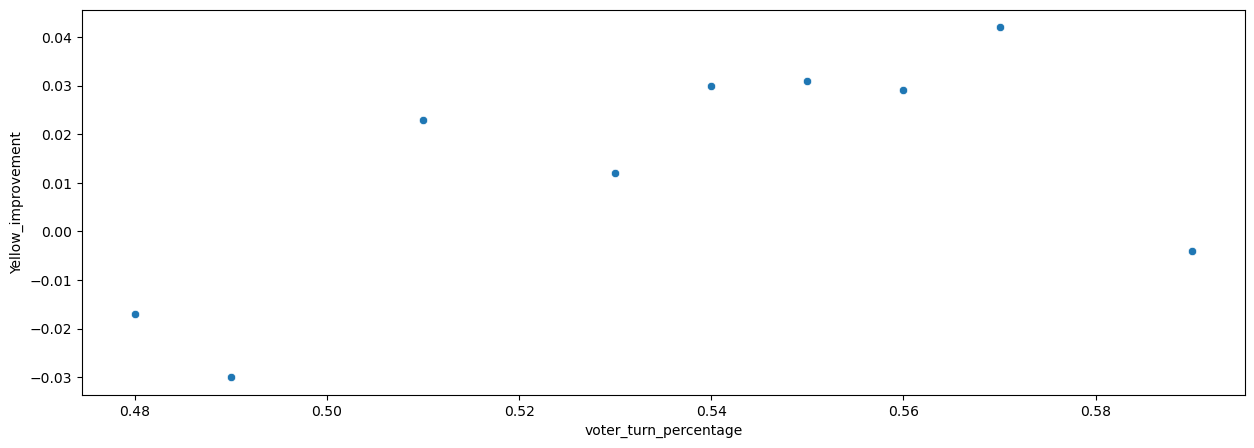

In [12]:
sns.scatterplot(data = past_vote_table, x = "voter_turn_percentage", y="Yellow_improvement")

In [13]:
y = np.array(past_vote_table["Yellow_improvement"]).reshape(-1,1)
x = np.array(past_vote_table["voter_turn_percentage"]).reshape(-1,1)

model = LinearRegression().fit(x, y)
adj = -model.predict(np.array(.6).reshape(1,-1))[0][0]
adj

np.float64(-0.03775359342915813)

## Start Your Work

### Part 1 - Election

In [17]:
# Do some stuff

dists = getPollDist(dist_polls)

purpWins = 0
nSim = 10000

for sim in range(nSim):
    simVotes = []
    for d in dists:
        tmpMean = float(d[0])
        tmpSD = float(d[1])
        vote = np.random.normal(tmpMean, tmpSD)
        simVotes.append(vote)
    
    purple_seats = 0
    for vote in simVotes:
        if vote > 0.5:
            purple_seats += 1
    
    if purple_seats >= 4:
        purpWins += 1

purpWinProb = purpWins / nSim
print(f"Probability Purple Party controls government: {purpWinProb:.1%}")

Probability Purple Party controls government: 76.6%


### Part 2 - Regression

<b>Use the data provided to try to predict the wage. </b>

The data is from FIFA rankings for players. You don't need to know anything about soccer or video games for this, so if these values are meaningless to you, just treat them as numbers and you'll be fine. All of the features are rankings are evaluations of how good different soccar players are at different skills.

#### Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul>
<li>
<li>
<li>
</ul>

In [18]:
df = pd.read_csv("players_20_2.csv")
df.head()

,wage_eur,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
0,565000,88,95,70,92,88,97,93,94,92,...,94,48,40,94,94,75,96,33,37,26
1,405000,84,94,89,83,87,89,81,76,77,...,93,63,29,95,82,85,95,28,32,24
2,290000,87,87,62,87,87,96,88,87,81,...,84,51,36,87,90,90,94,27,26,29
3,125000,13,11,15,43,13,12,13,14,40,...,12,34,19,11,65,11,68,27,12,18
4,470000,81,84,61,89,83,95,83,79,83,...,80,54,41,87,89,88,91,34,27,22


In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
wage_eur,18278.0,9456.942773,21351.714095,0.0,1000.0,3000.0,8000.0,565000.0
attacking_crossing,18278.0,49.718405,18.325403,5.0,38.0,54.0,64.0,93.0
attacking_finishing,18278.0,45.590218,19.594609,2.0,30.0,49.0,62.0,95.0
attacking_heading_accuracy,18278.0,52.221468,17.428429,5.0,44.0,56.0,64.0,93.0
attacking_short_passing,18278.0,58.748003,14.679653,7.0,54.0,62.0,68.0,92.0
attacking_volleys,18278.0,42.809388,17.701815,3.0,30.0,44.0,56.0,90.0
skill_dribbling,18278.0,55.596509,18.929118,4.0,50.0,61.0,68.0,97.0
skill_curve,18278.0,47.325692,18.422991,6.0,34.0,49.0,62.0,94.0
skill_fk_accuracy,18278.0,42.708885,17.433612,4.0,31.0,41.0,56.0,94.0
skill_long_passing,18278.0,52.768848,15.246454,8.0,43.0,56.0,64.0,92.0


In [ ]:
sns.pairplot(df.sample(1000))

<Axes: xlabel='wage_eur', ylabel='Density'>

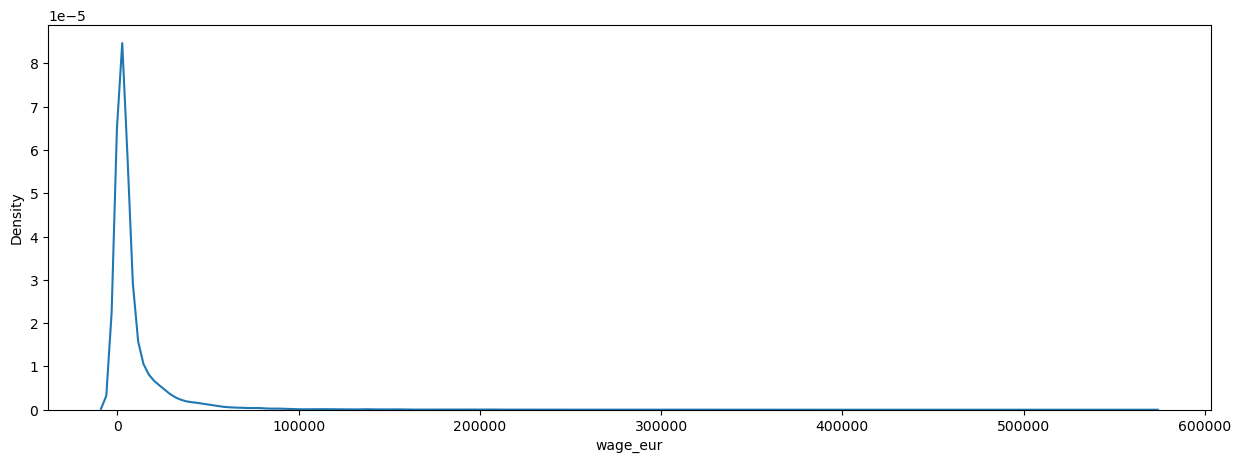

In [ ]:
sns.kdeplot(df["wage_eur"])

#### Clean some data

In [ ]:
df.isnull().sum().sort_values(ascending=False)

wage_eur                      0
attacking_crossing            0
attacking_finishing           0
attacking_heading_accuracy    0
attacking_short_passing       0
attacking_volleys             0
skill_dribbling               0
skill_curve                   0
skill_fk_accuracy             0
skill_long_passing            0
skill_ball_control            0
movement_acceleration         0
movement_sprint_speed         0
movement_agility              0
movement_reactions            0
movement_balance              0
power_shot_power              0
power_jumping                 0
power_stamina                 0
power_strength                0
power_long_shots              0
mentality_aggression          0
mentality_interceptions       0
mentality_positioning         0
mentality_vision              0
mentality_penalties           0
mentality_composure           0
defending_marking             0
defending_standing_tackle     0
defending_sliding_tackle      0
dtype: int64

In [ ]:


# Step 1: Load and preview data
df = pd.read_csv("players_20_2.csv")



# Step 2: Clean the dataset
df2 = df[(df["wage_eur"] > 10) & (df["wage_eur"] < 300000)].dropna()

# Step 3: Prepare data for regression
y = np.array(df2["wage_eur"]).reshape(-1, 1)

# Drop non-numeric and unnecessary columns safely
cols_to_drop = ["wage_eur", "short_name", "long_name", "club_name"]
existing = [c for c in cols_to_drop if c in df2.columns]
X = df2.drop(columns=existing).select_dtypes(include=[np.number])

# Step 4: Split into training/testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

# Step 6: Evaluate the model
from sklearn.metrics import r2_score, mean_absolute_error
y_pred = model.predict(x_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Step 7: Display formatted output (solution-style)
print("---------------------------------------------------")
print(" Model Evaluation Summary")

print(f"{'Training Samples:':30s}{len(x_train):>10}")
print(f"{'Testing Samples:':30s}{len(x_test):>10}")
print(f"{'R² Score:':30s}{r2:>10.4f}")
print(f"{'Mean Absolute Error (€):':30s}{mae:>10.2f}")


# Step 8: Show sample of predictions
print("Actual vs Predicted Wages (€):")
print("---------------------------------------------------")
results = pd.DataFrame({
    "Actual (€)": y_test.flatten()[:10],
    "Predicted (€)": y_pred.flatten()[:10]
})
print(results.to_string(index=False, justify='center', col_space=15))



---------------------------------------------------
 Model Evaluation Summary
---------------------------------------------------
Training Samples:                  14421
Testing Samples:                    3606
R² Score:                         0.3061
Mean Absolute Error (€):         8823.33
---------------------------------------------------

Actual vs Predicted Wages (€):
---------------------------------------------------
   Actual (€)     Predicted (€)
      9000        16362.732252 
      6000        17670.740176 
      7000        19482.066752 
      3000        17303.356341 
      1000        11178.643522 
      6000        17583.166467 
      6000        10066.036790 
      2000         8116.367608 
      1000         1050.998407 
      2000         9685.967378 
---------------------------------------------------


#### Examine Colinerarity

In [36]:
# --- Examine Collinearity ---

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Prepare numeric data
X = df2.select_dtypes(include=[np.number]).drop(columns=["wage_eur"])
X = X.fillna(0)

# Step 2: Calculate VIF for each variable
vifs = pd.DataFrame()
vifs["variables"] = X.columns
vifs["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vifs.sort_values(by="VIF", ascending=False))

# Step 3: Remove highly collinear variables
cols_to_remove = vifs[vifs["VIF"] > 10]["variables"].tolist()
df2_filt = X.drop(columns=cols_to_remove)
print(f"\nRemoved columns (VIF > 10): {cols_to_remove}")

# Step 4: Final filtered data
print(df2_filt.head())


                     variables         VIF
9           skill_ball_control  260.585688
3      attacking_short_passing  228.796108
10       movement_acceleration  176.600165
27   defending_standing_tackle  165.446905
5              skill_dribbling  165.391557
11       movement_sprint_speed  148.828188
28    defending_sliding_tackle  135.113126
13          movement_reactions  102.842223
12            movement_agility   97.288075
8           skill_long_passing   96.306272
25         mentality_composure   89.125289
15            power_shot_power   77.799162
22       mentality_positioning   77.441906
1          attacking_finishing   74.481981
21     mentality_interceptions   72.318969
23            mentality_vision   66.723708
19            power_long_shots   66.268341
14            movement_balance   64.026795
17               power_stamina   60.881500
6                  skill_curve   54.992195
18              power_strength   53.591419
0           attacking_crossing   52.250881
2   attacki

In [31]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Function will check the VIF of each variable in a DF and return the results in another DF
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

#Check VIFs
vifs_1 = calc_vif(df2).sort_values(by="VIF", ascending=False)
vifs_1

,variables,VIF
10,skill_ball_control,260.803678
4,attacking_short_passing,228.797552
11,movement_acceleration,176.645654
28,defending_standing_tackle,165.459399
6,skill_dribbling,165.412447
12,movement_sprint_speed,148.868759
29,defending_sliding_tackle,135.228897
14,movement_reactions,107.986396
13,movement_agility,97.682819
9,skill_long_passing,96.306809


In [32]:
cols_rem_1 = vifs_1["variables"].to_list()
cols_rem_1

['skill_ball_control',
 'attacking_short_passing',
 'movement_acceleration',
 'defending_standing_tackle',
 'skill_dribbling',
 'movement_sprint_speed',
 'defending_sliding_tackle',
 'movement_reactions',
 'movement_agility',
 'skill_long_passing',
 'mentality_composure',
 'power_shot_power',
 'mentality_positioning',
 'attacking_finishing',
 'mentality_interceptions',
 'mentality_vision',
 'power_long_shots',
 'movement_balance',
 'power_stamina',
 'power_strength',
 'skill_curve',
 'attacking_crossing',
 'mentality_penalties',
 'attacking_heading_accuracy',
 'defending_marking',
 'attacking_volleys',
 'power_jumping',
 'mentality_aggression',
 'skill_fk_accuracy',
 'wage_eur']

In [33]:
df2_filt_1 = df2.drop(columns=cols_rem_1[0:7])
df2_filt_1.head()

,wage_eur,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_volleys,skill_curve,skill_fk_accuracy,skill_long_passing,movement_agility,movement_reactions,...,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking
2,290000,87,87,62,87,88,87,81,96,92,...,81,49,84,51,36,87,90,90,94,27
3,125000,13,11,15,13,13,14,40,67,88,...,41,78,12,34,19,11,65,11,68,27
6,250000,18,14,11,14,18,12,63,37,86,...,35,78,10,43,22,11,70,25,70,25
7,200000,53,52,86,45,60,70,81,61,88,...,75,92,64,82,89,47,65,62,89,91
9,240000,79,90,59,79,83,69,75,91,92,...,85,73,84,63,55,92,84,77,91,38


In [34]:
y1 = np.array(df2_filt_1["wage_eur"]).reshape(-1,1)
x1 = np.array(df2_filt_1.drop(columns={"wage_eur"}))

xTrain1, xTest1, yTrain1, yTest1 = train_test_split(x1,y1)

model1 = LinearRegression().fit(xTrain1, yTrain1)
preds1 = model1.predict(xTest1)
r21 = model1.score(xTest1, yTest1)
rmse1 = root_mean_squared_error(yTest1, preds1)
print("RMSE:", rmse1, "\nR2:", r21)


RMSE: 17452.931091375875 
R2: 0.29204439616325173


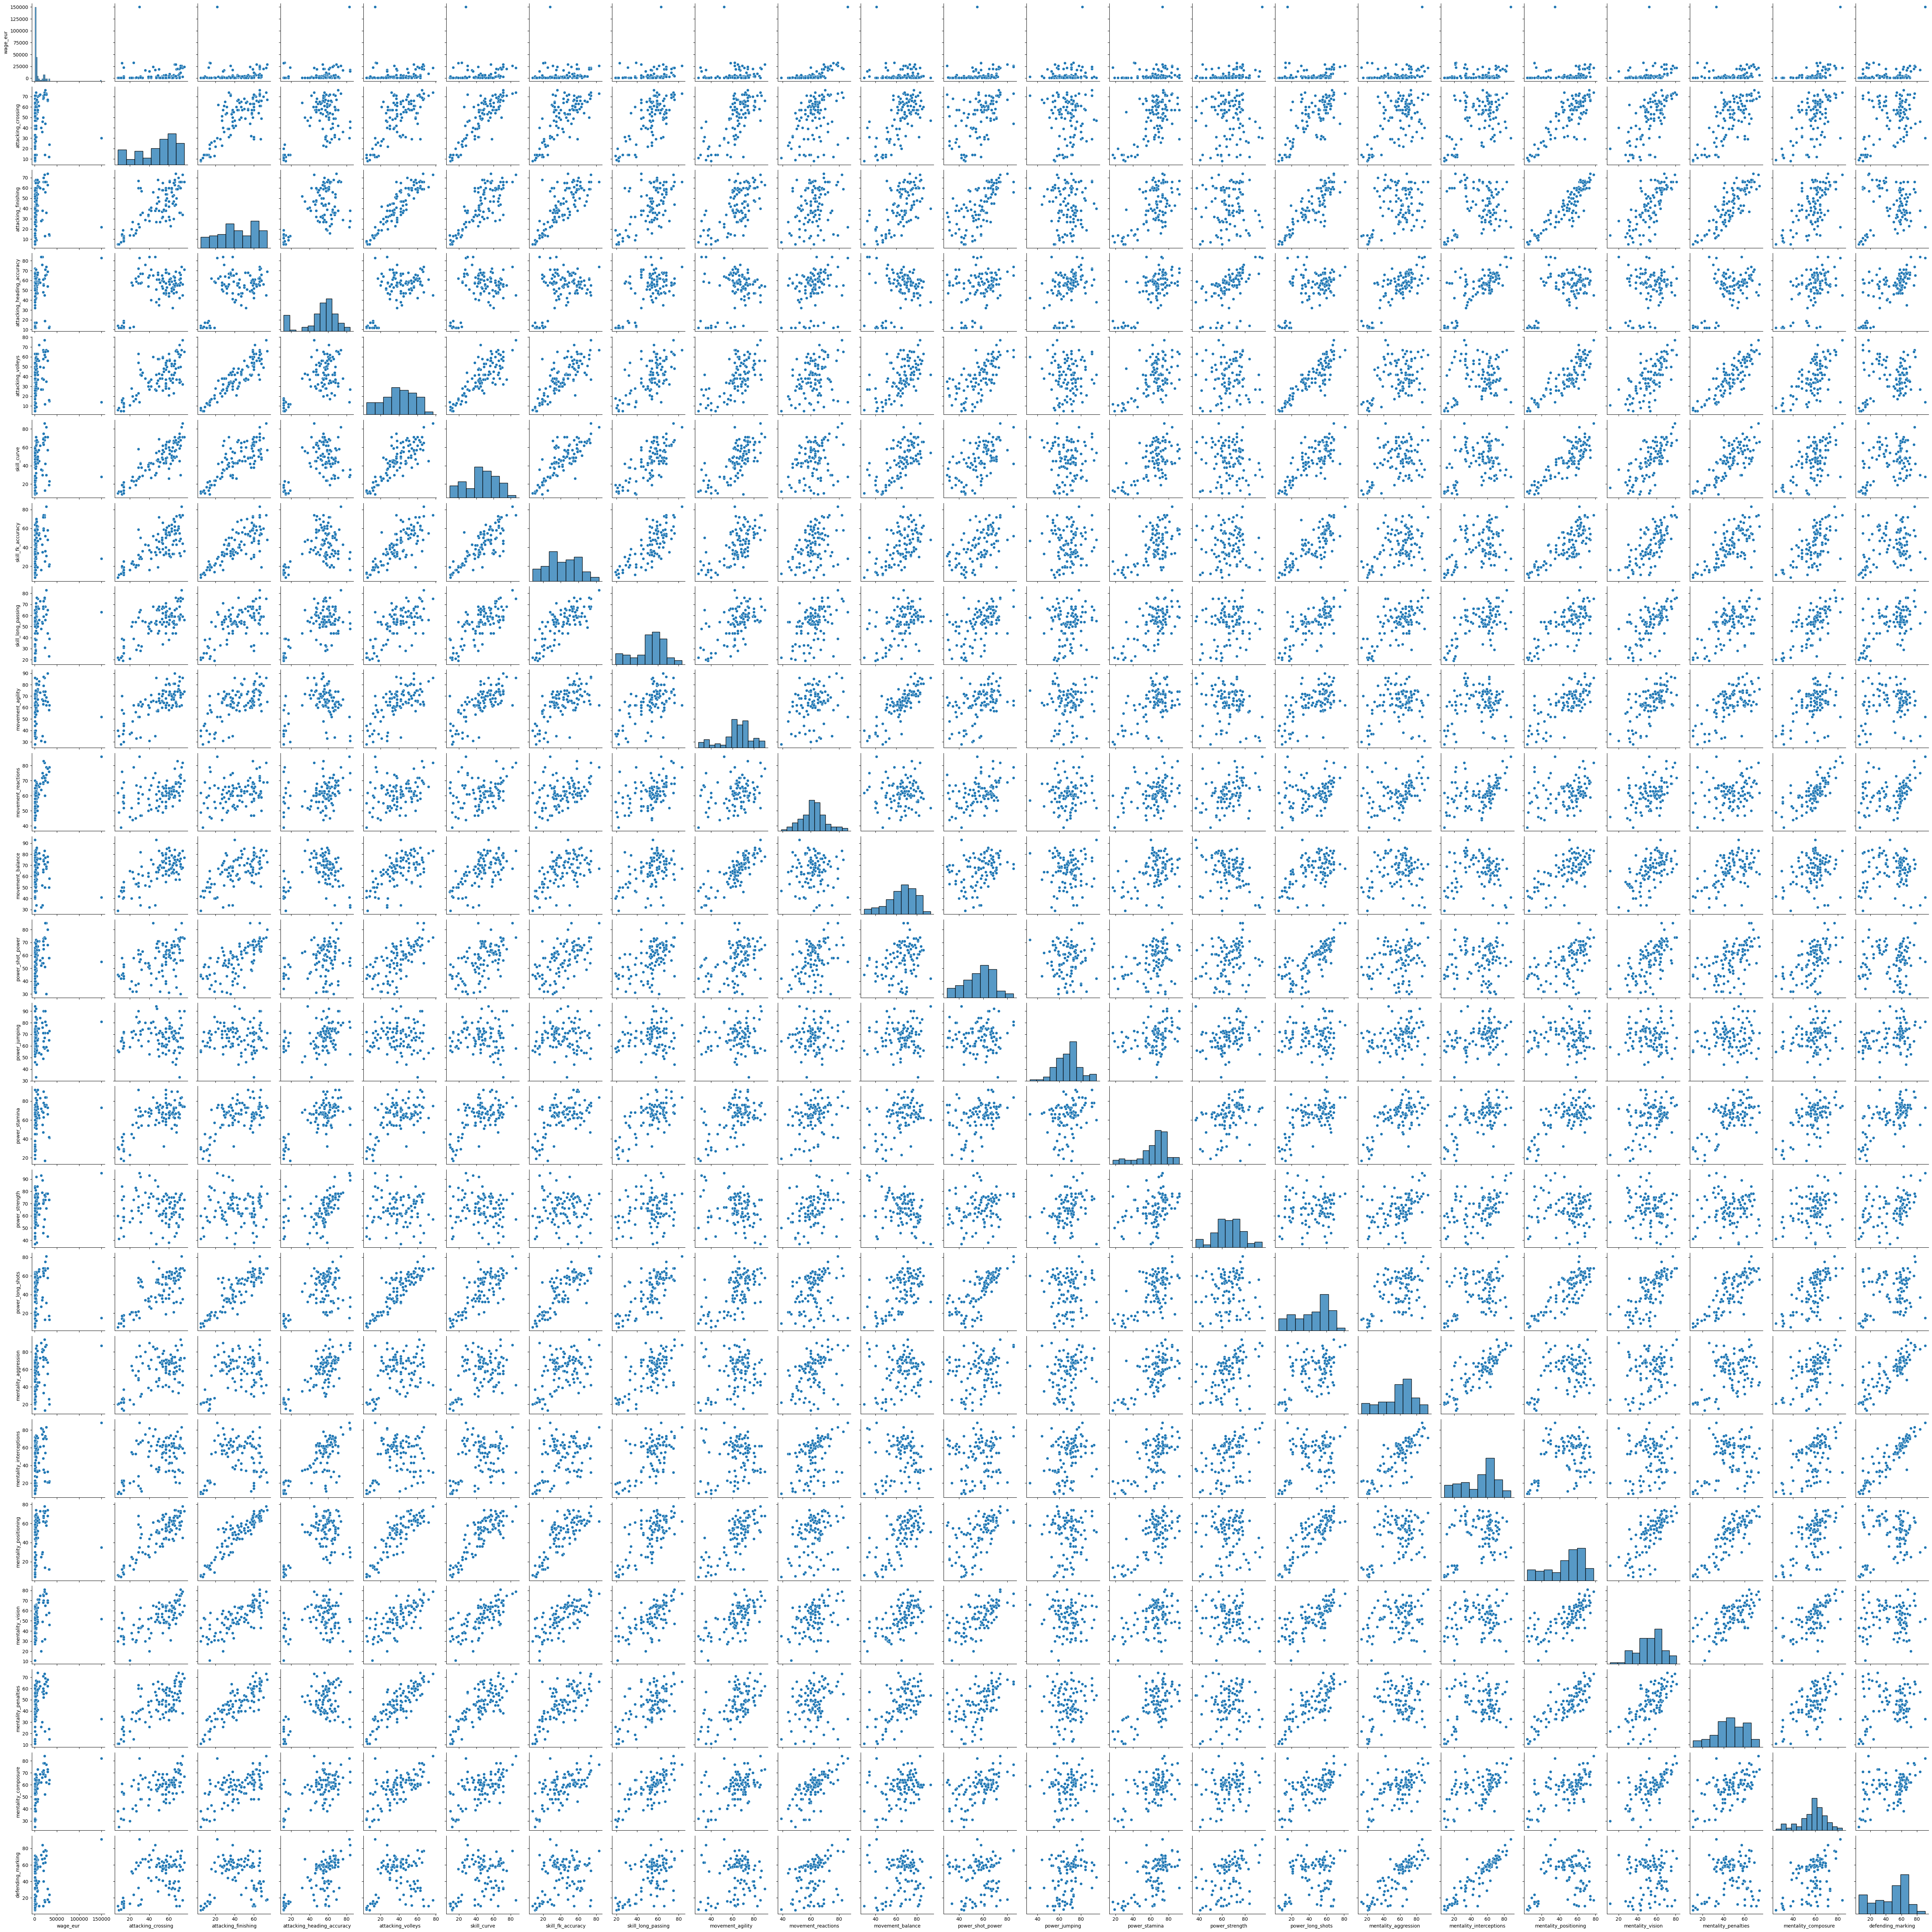

In [35]:
sns.pairplot(df2_filt_1.sample(100))